# 6章 GLMの応用範囲を広げる

## 6.3 二項分布で表現する「あり・なし」のカウントデータ

In [31]:
import scipy.misc

In [33]:
def calc_binomial(N, q):
    ret = []
    for y in range(N+1):
        comb = scipy.misc.comb(N, y)
        ret.append(comb * (q**y)*((1-q)**(N-y)))
    return ret

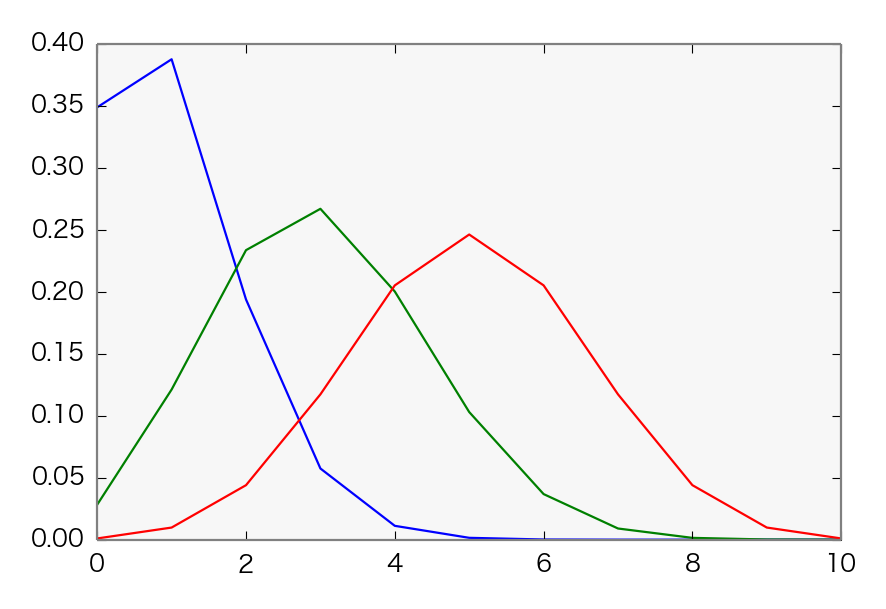

In [38]:
plt.plot(calc_binomial(10, 0.1))
plt.plot(calc_binomial(10, 0.3))
plt.plot(calc_binomial(10, 0.5))

In [46]:
def logistic(z):
    return 1/float(1 + np.exp(-1 * z))
logistic = np.vectorize(logistic)

ロジスティック関数

$q_i = logistic(z_i) = \frac{1}{1 + exp(-z_i)}$

変形すると

$log\frac{q_i}{1 - q_i} = z_i$

この左辺をロジット関数 $logit(q_i)$と言う

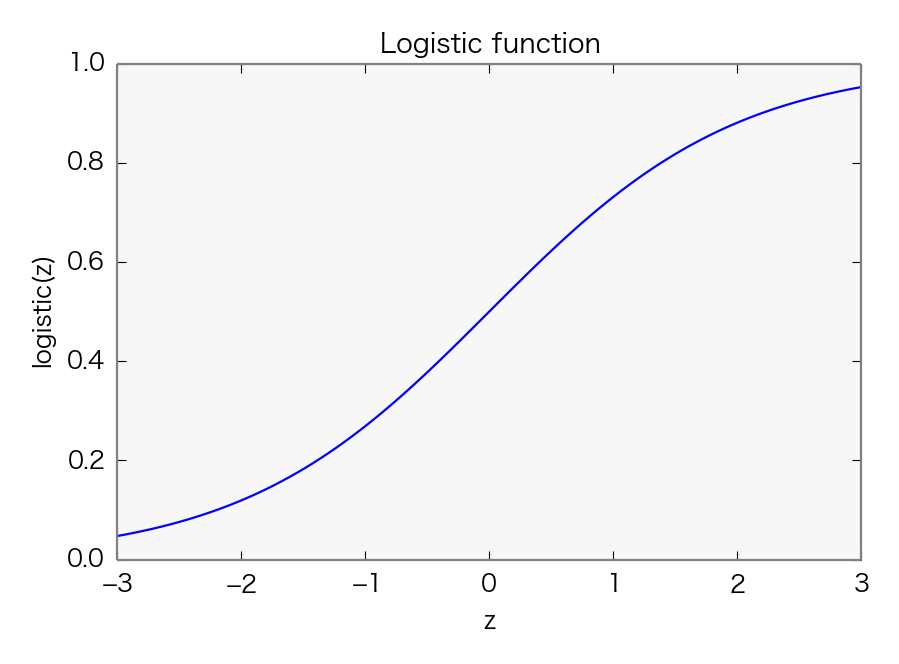

In [50]:
X = np.linspace(-3, 3, 100)
plt.plot(X, logistic(X))
plt.xlabel('z')
plt.ylabel('logistic(z)')
plt.title('Logistic function')

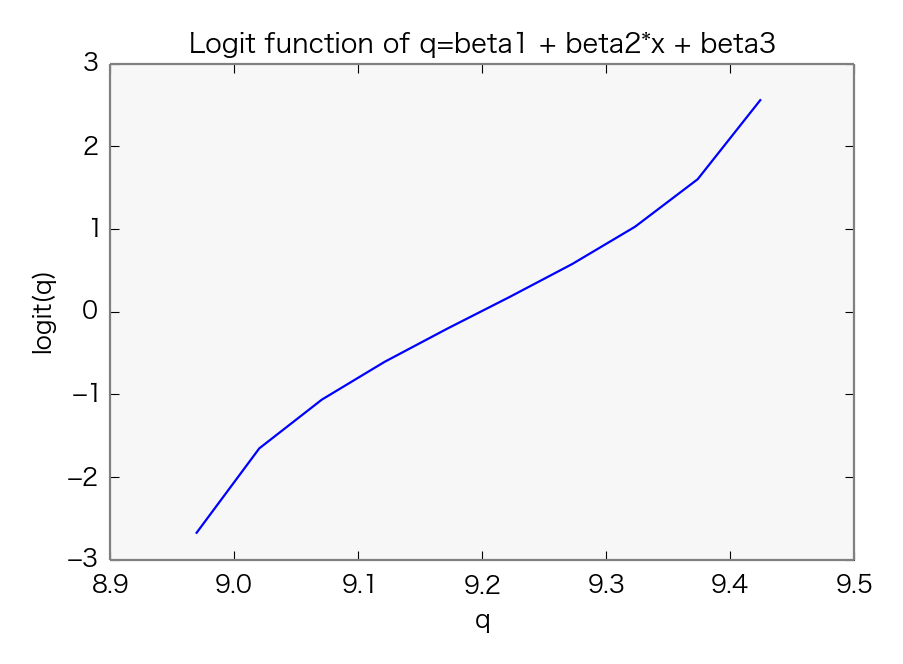

In [57]:
def logit(x):
    q = -19 + x*1.9 + 2.022
    return np.log(q/float(1-q))
logit = np.vectorize(logit)

X = np.linspace(7, 12, 100)
plt.plot(X, logit(X))
plt.xlabel('q')
plt.ylabel('logit(q)')
plt.title('Logit function of q=beta1 + beta2*x + beta3')


## 6.4.1 ロジットリンク関数の解釈

$\displaystyle
\begin{align*}
\frac{q_i}{1 - q_i}
&=
exp(線形予測子) \\
&=
exp(\beta_1 + \beta_{2}x_{i} + \beta_{3}f_i) \\
&=
exp(\beta_1)exp(\beta_{2}x_{i})exp(\beta_{3}f_i) \\
\end{align*}
$


In [ ]:
わりざんはやめよう

In [ ]:
CPAに関する何かに使える?